Smoothed NDVI

In [1]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from p_drought_indices.functions.ndvi_functions import get_irradiances, compute_ndvi_corr

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

ndvi_dir = config_file['NDVI']['ndvi_prep']
    
new_dir = os.path.join(ndvi_dir,"new_process")
list_files_2 = [os.path.join(new_dir, f) for f in os.listdir(new_dir) if f.endswith(".nc")]

ds = xr.open_dataset(list_files_2[1000])

msg_type = ds.attrs['EPCT_product_name'][:4]

girradiance_vis6, irradiance_vis8 = get_irradiances(msg_type)

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2023-07-05 17:09:28.510780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

CONFIG_PATH= "../config.yaml"

config_file = load_config(CONFIG_PATH=CONFIG_PATH)

# Open the NetCDF file with xarray
ds = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'ndvi_no_out.nc'))
ds_ndvi = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_prep'], 'final_ndvi.nc'))
ds_smoot = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))
vci = xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'vci_1D.nc'))

In [ ]:
import pandas as pd 
from datetime import timedelta

from p_drought_indices.analysis.visualizations.viz_series import plot_ndvi_days

plot_ndvi_days(ds_smoot,
               start_day="2010-01-01",
                num_timesteps=15)

In [1]:
import xarray as xr
import numpy as np
import torch
from torchvision import transforms
import os
from p_drought_indices.functions.function_clns import load_config, prepare, CNN_preprocessing, get_lat_lon_window
import numpy as np
import torch
from torch.utils.data import Dataset
from p_drought_indices.analysis.DeepLearning.dataset import CustomDataset
from torch.utils.data import DataLoader
import pickle

CONFIG_PATH= "../config.yaml"

time_end = "2019-12-31"
time_start = "2005-01-01"


def spi_ndvi_convlstm():
    config_file = load_config(CONFIG_PATH=CONFIG_PATH)

    # Open the NetCDF file with xarray
    dataset = prepare(xr.open_dataset(os.path.join(config_file['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))).sel(time=slice(time_start,time_end))

    prod = "ERA5"
    late = 90

    path = config_file['SPI']['ERA5']['path']
    file = f"ERA5_spi_gamma_{late}.nc"
    precp_ds = xr.open_dataset(os.path.join(path, file))
    var_target = "spi_gamma_{}".format(late)
    print(f"The {prod} raster has spatial dimensions:", precp_ds.rio.resolution())

    #### training parameters
    train_split = 0.8
    batch_size=4
    dim=64
    preprocess_type="nearest"

    ### Load dataset
    file_path = os.path.join(config_file["DEFAULT"]["data"],'preprocessed_data.pkl')
    if os.path.exists(file_path):
        print("The file exists. Proceeding with the analysis")
        with open(file_path, 'rb') as file:
            train_data, test_data, train_label, test_label = pickle.load(file)
    else:
        print("The file does not exist. Proceeding with preprocessing")
        idx_lat, lat_max, idx_lon, lon_min = get_lat_lon_window(precp_ds, dim)
        sub_precp = prepare(precp_ds).sel(time=slice(time_start,time_end))\
            .sel(lat=slice(lat_max, idx_lat), lon=slice(lon_min, idx_lon))
        ds = dataset["ndvi"].rio.reproject_match(sub_precp[var_target]).rename({'x':'lon','y':'lat'})

        

        train_data, test_data, train_label, test_label = CNN_preprocessing(ds, sub_precp, var_origin="ndvi", var_target=var_target, preprocess_type=preprocess_type,  split=train_split)
        # Save the image data using pickle
        with open(file_path, 'wb') as file:
            pickle.dump((train_data, test_data, train_label, test_label), file)
        print("Data written to pickle file")

    # create a CustomDataset object using the reshaped input data
    train_dataset = CustomDataset(train_data, train_label)
    test_dataset = CustomDataset(test_data, test_label)
    
    # create a DataLoader object that uses the dataset
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    
    ### check shape of data
    
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.float()
        targets = targets.float()
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())
    
    
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs = inputs.float()
        targets = targets.float()
        print(inputs.shape, targets.shape, inputs.max(), inputs.min())


    #### Start training

    from p_drought_indices.configs.config_3x3_16_3x3_32_3x3_64 import config
    from torch.nn import MSELoss
    import matplotlib.pyplot as plt
    from p_drought_indices.analysis.DeepLearning.ConvLSTM import ConvLSTM, train_loop, valid_loop, build_logging
    import numpy as np
    
    name = '3x3_16_3x3_32_3x3_64'
    
    logger = build_logging(config)
    model = ConvLSTM(config).to(config.device)
    #criterion = CrossEntropyLoss().to(config.device)
    #criterion = torch.nn.MSELoss().to(config.device)
    criterion = MSELoss().to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_records, valid_records, test_records = [], [], []
    for epoch in range(config.epochs):
        epoch_records = train_loop(config, logger, epoch, model, train_dataloader, criterion, optimizer)
        train_records.append(np.mean(epoch_records['loss']))
        epoch_records = valid_loop(config, logger, epoch, model, test_dataloader, criterion)
        valid_records.append(np.mean(epoch_records['loss']))
        plt.plot(range(epoch + 1), train_records, label='train')
        plt.plot(range(epoch + 1), valid_records, label='valid')
        plt.legend()
        plt.savefig(os.path.join(config.output_dir, '{m}_{n}.png'.format(n=name, m=preprocess_type)))
        plt.close()
    

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2023-07-05 18:29:07.576960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The ERA5 raster has spatial dimensions: (0.25, -0.25)
The file exists. Proceeding with the analysis
torch.Size([1, 4382, 1, 64, 64]) torch.Size([1, 4382, 1, 64, 64]) tensor(3.0900) tensor(-3.0900)
torch.Size([1, 1096, 1, 64, 64]) torch.Size([1, 1096, 1, 64, 64]) tensor(3.0900) tensor(-3.0900)
/media/BIFROST/N2/Riccardo/Indices_analysis/notebooks/.
tensor(3.0900, dtype=torch.float64)


UnboundLocalError: local variable 'preprocess_type' referenced before assignment

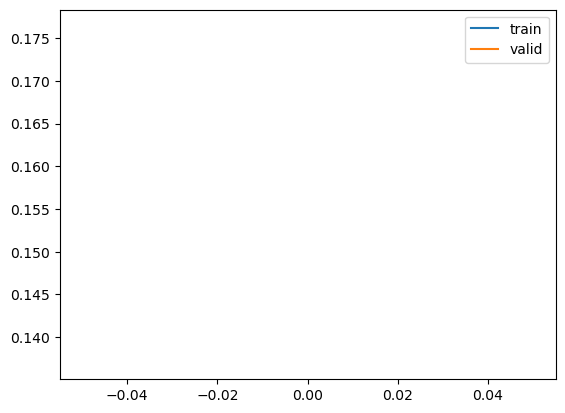

In [2]:
spi_ndvi_convlstm()